# Определение стоимости автомобилей

## Цель
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. **Нужно построить модель для определения стоимости.** 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Значение метрики RMSE должно быть меньше 2500.**

In [1]:
!pip install catboost --quiet
!pip install category_encoders --quiet

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from category_encoders import TargetEncoder
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
 

warnings.filterwarnings('ignore')

RANDOM_STATE = 12345

In [2]:
# Напишем функцию для первичной проверки данных
def check_data(data_df):
    print ('\033[1m' + 'Изучим исходные данные'+ '\033[0m')
    print(data_df.info())
    #print(data_df.shape)
        
    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())
        
    ## Посмотрим на сами данные
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data_df.head())
    
    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data_df.describe().T)
    
    print('\033[1m' + '\nОписание категориальных данных:'+ '\033[0m')
    display(data_df.describe(include='object').T) 
    
    
    print('\033[1m' + '\nВывод уникальных значений по каждому категориаьному признаку:'+ '\033[0m')    
    df_object = data_df.select_dtypes(include='object').columns
    
    for i in df_object:
        print('\033[1m' + '_'+ str(i) + '\033[0m')
        display(data_df[i].value_counts())

In [5]:
def cat_graph(df, cat_feat):
    '''
    Функция отрисовки круговых диаграмм для категориальных переменных.
    На вход: исходная таблица и список категориальных переменных.
    На выходе: графики
    '''
        
    cols = 2
    rows = int(np.ceil(len(cat_feat) / cols))

    fig, axs = plt.subplots(rows, cols, figsize = (14,14))
    plt.tight_layout()

    count = -1
    for i in range(rows):
        for x in range(cols):
            count+=1
            col = cat_feat[count]
            df1 = pd.DataFrame(df.groupby([col])[col].count())
            axs[i,x].pie(x=df1[col],
                         labels=df1.index, 
                         autopct='%1.0f%%',)
            axs[i,x].title.set_text(str(col))

    plt.suptitle('Круговые диаграммы категориальных признаков', fontsize=22, y=1.05)

    plt.show()

In [6]:
def plot_hist(data, col_column):
    '''
    Функция отрисовки гистограмм и ящика с усами для количесвтенных переменных.
    На вход: исходная таблица и список количественных переменных.
    На выходе: графики
    '''
    rows = len(col_column)
    f, ax = plt.subplots(rows,2, figsize=(15, 8))
    f.tight_layout()
    f.set_figheight(30)
    f.set_figwidth(14)
    plt.rcParams.update({'font.size': 18})
    
    for i, col in enumerate(col_column):         
        sns.histplot(data[col], kde=True, bins=24, ax = ax[i, 0])                    
        sns.boxplot(data[col], ax = ax[i, 1])

        ax[i, 0].set_xlabel(col)
        ax[i, 1].set_xlabel(col)
        ax[i, 0].set_ylabel('Количество')
    plt.suptitle("Гистограмма и ящик с усами для количесвтенных данных", fontsize=22, y=1.01)
    plt.show()

## Подготовка данных


In [7]:
# загружаем данные
df = pd.read_csv('/datasets/autos.csv')

In [8]:
# Посмотрим общую информацию и описание исходного датафрейма
check_data(df)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dt

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0



Описание категориальных данных:


,count,unique,top,freq
DateCrawled,354369,271174,2016-03-24 14:49:47,7
VehicleType,316879,8,sedan,91457
Gearbox,334536,2,manual,268251
Model,334664,250,golf,29232
FuelType,321474,7,petrol,216352
Brand,354369,40,volkswagen,77013
Repaired,283215,2,no,247161
DateCreated,354369,109,2016-04-03 00:00:00,13719
LastSeen,354369,179150,2016-04-06 13:45:54,17



Вывод уникальных значений по каждому категориаьному признаку:
_DateCrawled


2016-03-24 14:49:47    7
2016-03-26 22:57:31    6
2016-03-19 21:49:56    6
2016-04-02 14:50:21    5
2016-03-16 13:47:44    5
                      ..
2016-03-28 15:47:53    1
2016-03-28 19:36:35    1
2016-03-29 20:38:18    1
2016-03-28 21:45:59    1
2016-03-17 19:46:25    1
Name: DateCrawled, Length: 271174, dtype: int64

_VehicleType


sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

_Gearbox


manual    268251
auto       66285
Name: Gearbox, dtype: int64

_Model


golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 250, dtype: int64

_FuelType


petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

_Brand


volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64

_Repaired


no     247161
yes     36054
Name: Repaired, dtype: int64

_DateCreated


2016-04-03 00:00:00    13719
2016-04-04 00:00:00    13317
2016-03-20 00:00:00    12918
2016-03-12 00:00:00    12840
2016-03-21 00:00:00    12691
                       ...  
2016-01-15 00:00:00        1
2016-01-08 00:00:00        1
2014-03-10 00:00:00        1
2015-06-18 00:00:00        1
2015-08-10 00:00:00        1
Name: DateCreated, Length: 109, dtype: int64

_LastSeen


2016-04-06 13:45:54    17
2016-04-07 09:44:27    16
2016-04-07 09:45:10    16
2016-04-06 01:15:23    16
2016-04-06 09:17:58    16
                       ..
2016-03-24 10:48:20     1
2016-03-31 13:46:16     1
2016-03-27 03:16:53     1
2016-03-25 13:47:39     1
2016-03-12 15:43:42     1
Name: LastSeen, Length: 179150, dtype: int64

Найдено 4 явных дубликата. Удалим их позже, поскольку количество дубликатов за время манипуляция с данными может стать больше.

In [10]:
# Посмотрим в какие года анкет скачивались из базы (DateCrawled), 
#анкеты былт созданы (DateCreated) и пользователи активничали (LastSeen)
for col in ['DateCrawled', 'DateCreated', 'LastSeen']:
    pd.to_datetime(df[col], format='%Y-%m-%dT%H:%M:%S')
    print( pd.DatetimeIndex(df[col]).year.unique())

Int64Index([2016], dtype='int64', name='DateCrawled')
Int64Index([2016, 2015, 2014], dtype='int64', name='DateCreated')
Int64Index([2016], dtype='int64', name='LastSeen')


Далее удалим эти три столбца с датами. 

Дата выгрузки и дата посещения сайта не влияют на цену. Дата создания объявления теоретически может быть связана с ценой, так как обычно быстро расходятся товары с заниженными ценами, а долго висят товары с завышенными. К сожалению, в данном слуае, мы не знаем какие авто проданы, а какие нет, и не знаем дату продажи авто. Акстивность пользователя так же не дает представления о том продано авто или нет и когда оно продано, так как если в объявлении указан телефон, то можно зайти на сайт лишь один раз при создании анкетв, при этом могут быть мелкие и крупные салоны, которые продают сразу много машин и заходят на сайт постоянно.

Также удалим признак NumberOfPictures, как видно из описания данных выше, в этом столбце одни нули

Признак RegistrationMonth также не нужен, так как в данном случае будет достаточно года 

PostalCode мог бы влиять на цену, если бы у нас были данные по сильно разным регионам. Из-за пошлин, региональных особенностей комплектаций и других причин один и тот же автомобиль может стоить по-разному в разных странах. Мы же видимо имеем дело по крайней мере с одной и той же страной, поэтому местоположение владельца не будет влиять на цену. Удалим и этот столбец.

In [11]:
df = df.drop(columns=['DateCrawled','DateCreated','LastSeen', 'NumberOfPictures', 'RegistrationMonth', 'PostalCode'])

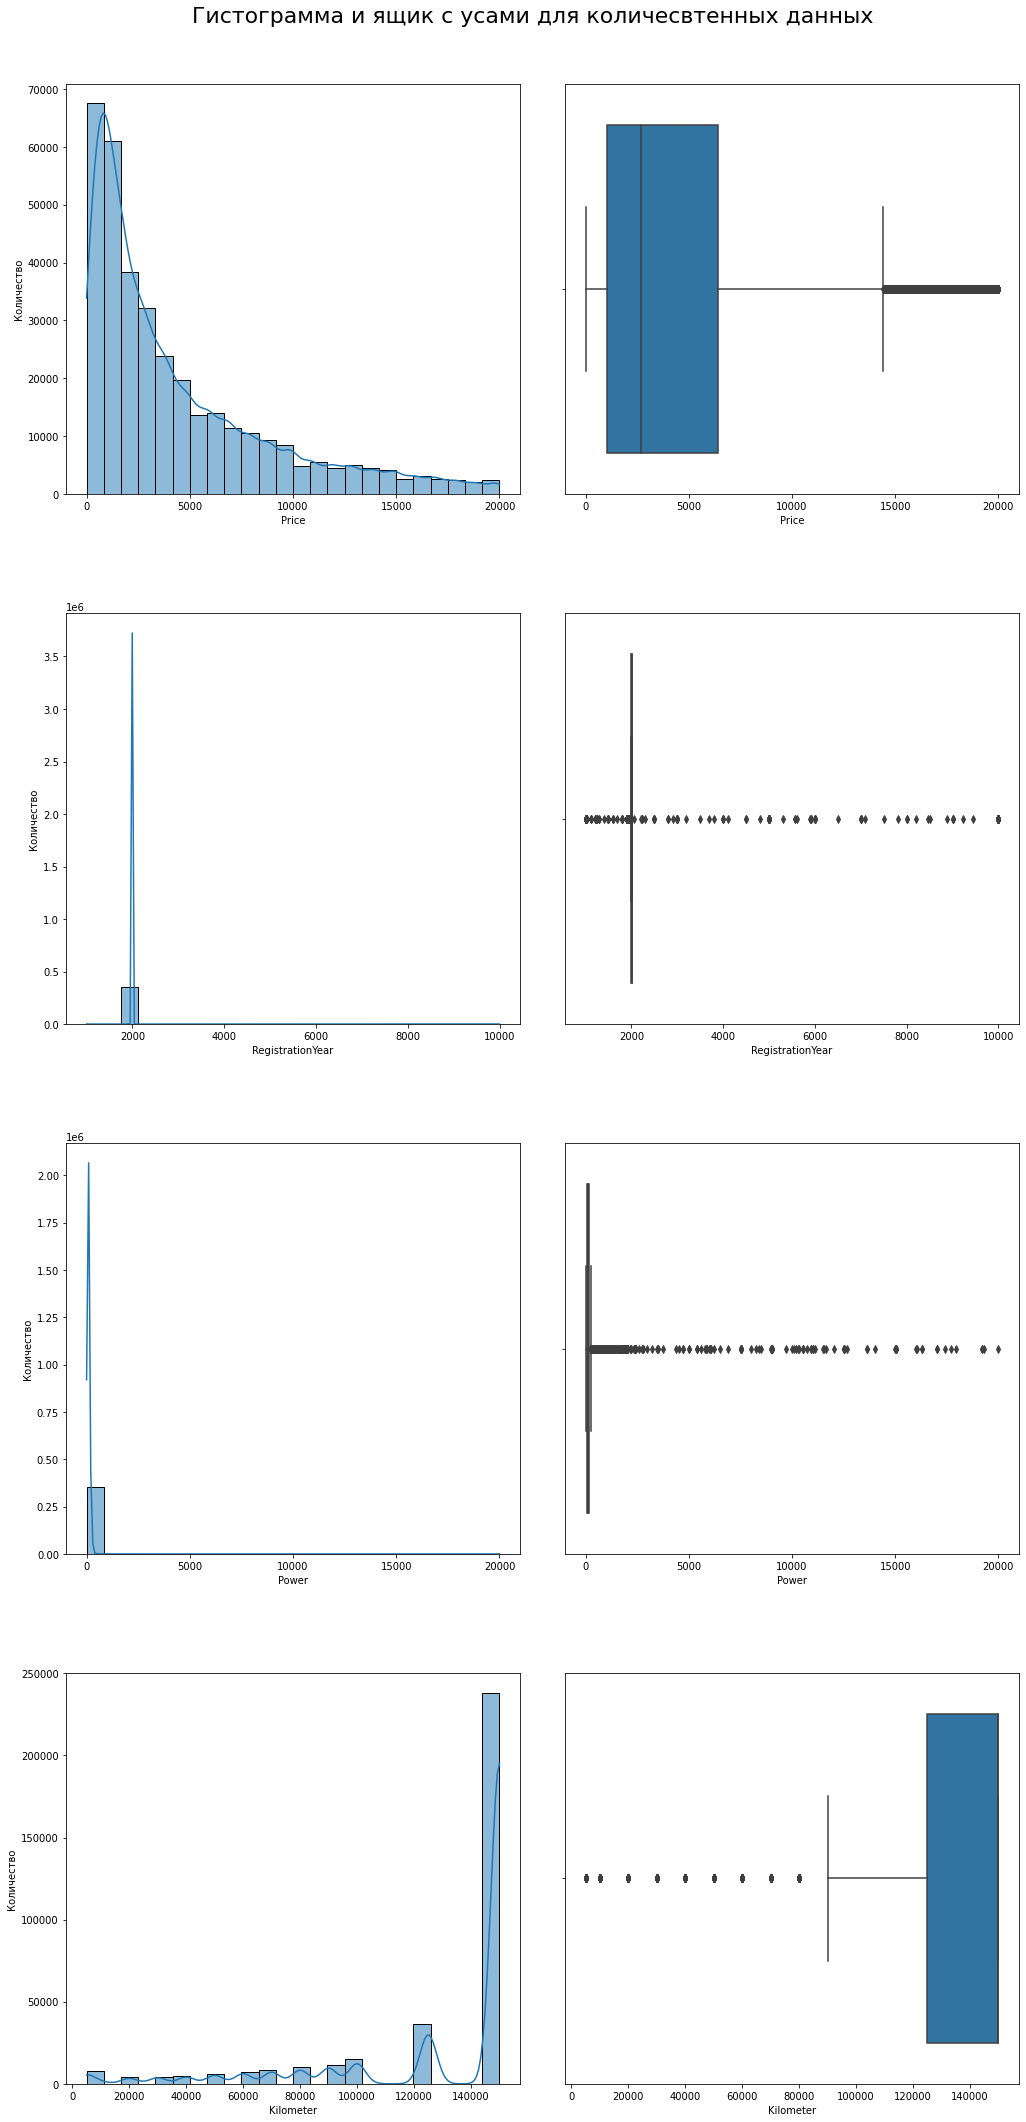

In [12]:
# Далее изучим количественные признаки
plot_hist(df, df.select_dtypes(exclude=[object]).columns)

In [13]:
# Аномальные значения в признаке "Цена":
# максимальное значение 20000 выглядит адекватным:
df.query('Price == 20000').head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1515,20000,sedan,2010,auto,239,a6,150000,gasoline,audi,no
1586,20000,sedan,2014,auto,184,leon,40000,gasoline,seat,no
2128,20000,sedan,2014,manual,135,ceed,30000,petrol,kia,no
3728,20000,sedan,2011,auto,265,c_klasse,50000,gasoline,mercedes_benz,no
6286,20000,sedan,2009,auto,272,e_klasse,150000,gasoline,mercedes_benz,no


<AxesSubplot:>

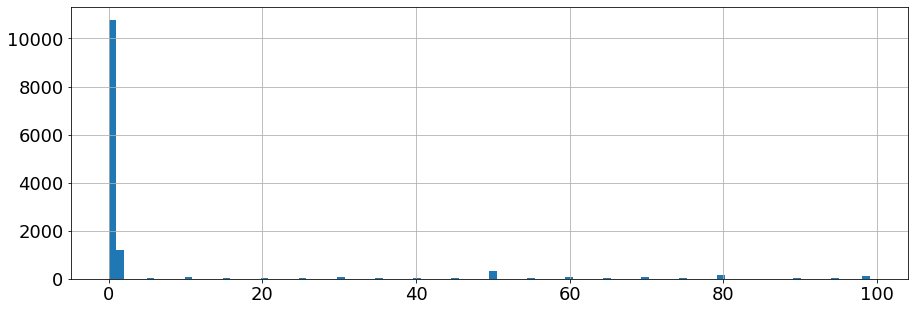

In [14]:
#посмотрим на гистограмму для очень маленьких цен
df.query('Price < 100')['Price'].hist(bins=100,figsize=(15,5))

In [15]:
df.query('Price == 0').head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN
111,0,NaN,2017,manual,0,golf,5000,petrol,volkswagen,NaN
115,0,small,1999,NaN,0,NaN,5000,petrol,volkswagen,NaN
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
154,0,NaN,2006,NaN,0,other,5000,NaN,fiat,NaN
231,0,wagon,2001,manual,115,mondeo,150000,NaN,ford,NaN
334,0,NaN,2005,NaN,0,polo,150000,petrol,volkswagen,NaN
415,0,NaN,1985,NaN,0,3er,150000,NaN,bmw,NaN
466,0,NaN,2016,auto,197,3er,150000,gasoline,bmw,no


In [16]:
df.query('0 < Price < 30').head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
59,1,suv,1994,manual,286,NaN,150000,NaN,sonstige_autos,NaN
89,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no
268,1,sedan,1990,manual,90,80,70000,petrol,audi,no
408,1,NaN,2000,NaN,75,golf,90000,petrol,volkswagen,NaN
901,1,NaN,1990,manual,0,other,150000,NaN,porsche,NaN
967,1,wagon,1998,manual,136,omega,150000,petrol,opel,no
1025,3,convertible,1998,manual,110,mx_reihe,150000,NaN,mazda,yes
1247,1,sedan,1983,manual,0,NaN,150000,petrol,mercedes_benz,no
1340,1,NaN,2016,manual,0,golf,150000,gasoline,volkswagen,yes
1542,1,NaN,2000,NaN,0,astra,150000,NaN,opel,NaN


В целом, изучив данные об авто с минимальными ценами можно предположить, что это авто в практически или полностью нерабочем состоянии. Большенство дешевых авто имеет пробег 15000 км при этом это максимальное и самое распространенное значение пробега в датасете. Те же, что имеют меньший пробег, возможно или точно repaired или очень старые. Выше в таблицах можно увидеть, напрмер bmw 3r и volkswagen golf, которые за 2016-ый год успели проездись все свои 150000 км, старый volkswagen 1980-го года, audi 80 1990-го за бесплатно или за очень маленькие деньги. Выбивается из общей картины volkswagen 2017-го года, но вспомним, что данные у нас выгружены в 2016-ом , так что это аномалия, которую обработаем далее.

Цены у нас указаны в евро и проедположу, что это данные по какой-то Европейской стране, где довольно дорого содержать или утилизировать автомобиль,  поэтому люди готовы избавиться от своих машин за низкую цену.

Нулевые цены удалим. Давать нашей модели понимание того, что автомобиль может быть бесплатным - не очень хорошая идея, такой результат может разочаровать пользователя приложения.   

In [17]:
df = df.query('Price > 0')

In [18]:
# ПОсмотрим уникальные значения года регистрации
df['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1234, 1255, 1300, 1400, 1500, 1600, 1602,
       1800, 1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222,
       2290, 2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500,
       4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 6500, 7000, 7100,
       7800, 8000, 8200, 8500, 8888, 9000, 9450, 9999])

<AxesSubplot:>

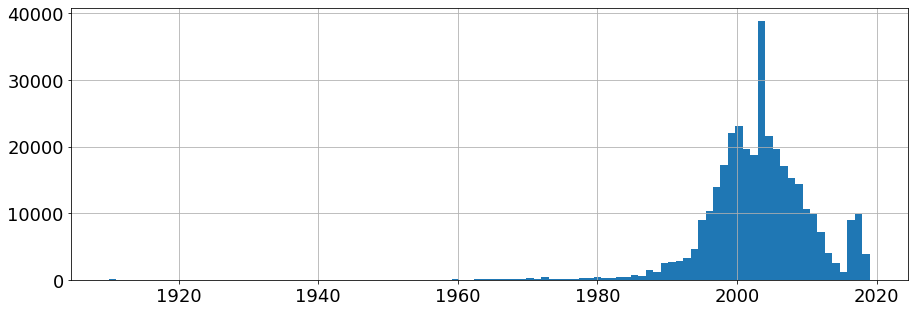

In [19]:
df.query('1900 <= RegistrationYear <= 2019')['RegistrationYear'].hist(bins=102,figsize=(15,5))

Тут есть очевидно аномальные данные, это года до 1900-го и после 2016-го. Далее удалим их , а также удалим строки с авто зарегестрированными до 1970-го, так как очень старые автомоили могут цениться очень высоко как раритетные, а могут быть отровенной рухлядью. Так что если мы оставим данные об очень старых авто, то может пострадать качество предсказаний.

Отметим, что очень странно выглядят года 2017, 2018, 2019, как-будто это не аномалии, а данные из будущего, поэтому в данном проекте будем исходить из того, что это аномальные данные и удалим их, но при первой возможности проверим пространство на наличие временных воронок.

In [20]:
df = df.query('1970 <= RegistrationYear <= 2016')

<AxesSubplot:>

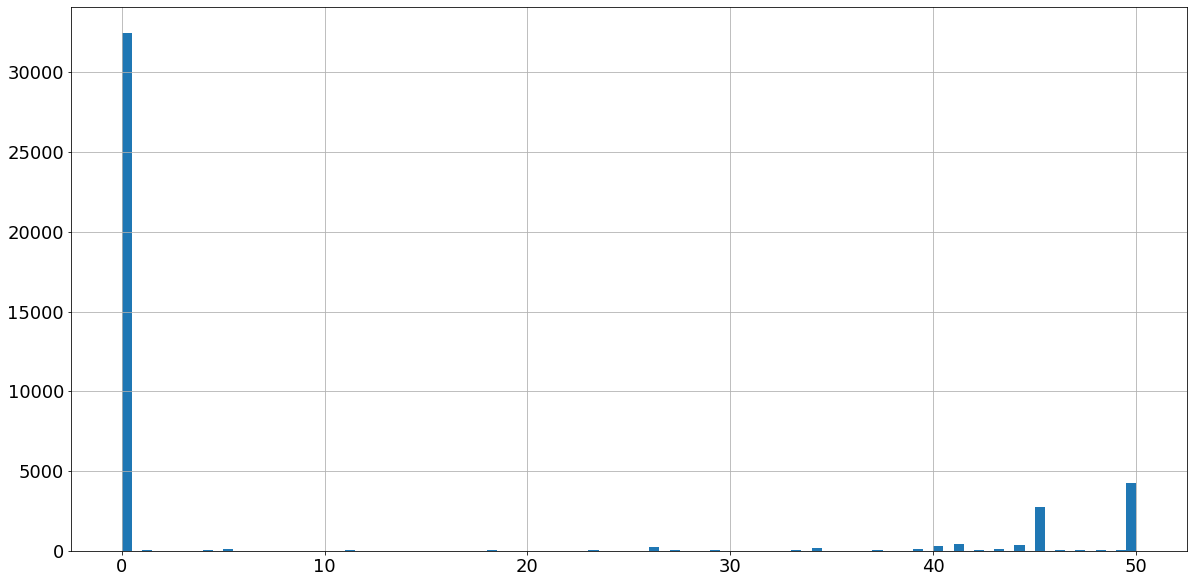

In [21]:
# изучим столбец "Мощность", начнем с маленьких значений
df.query('0 <= Power <= 50')['Power'].hist(bins=100,figsize=(20, 10))

In [22]:
df.query('Power == 0').head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
32,245,sedan,1994,NaN,0,golf,150000,petrol,volkswagen,no
37,1500,NaN,2016,NaN,0,kangoo,150000,gasoline,renault,no
54,4700,wagon,2005,manual,0,signum,150000,NaN,opel,no
55,550,wagon,1999,manual,0,astra,150000,gasoline,opel,yes


<AxesSubplot:>

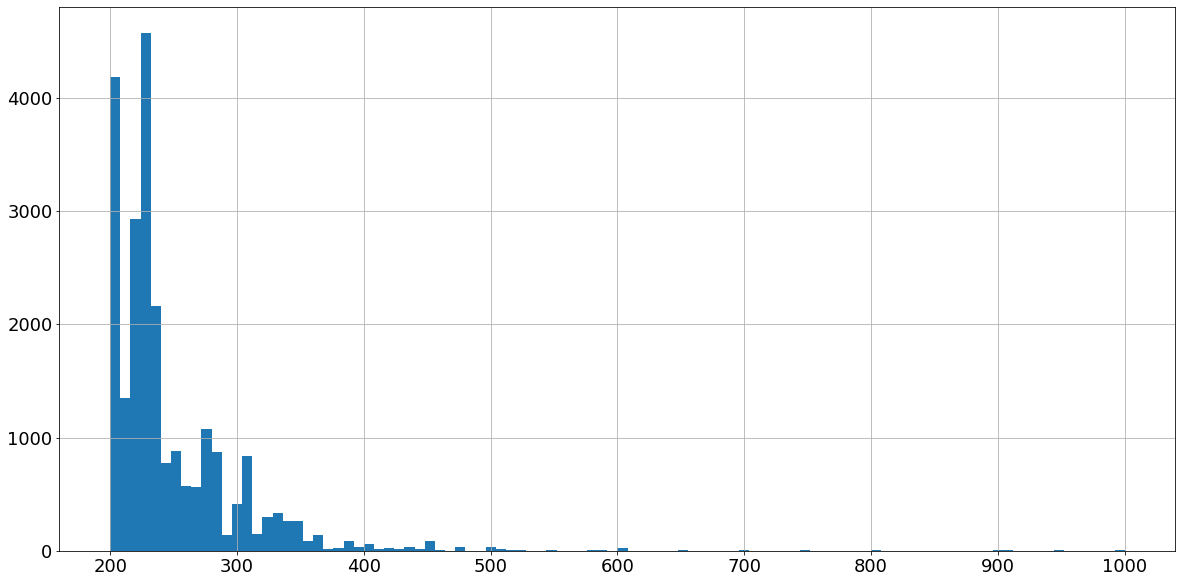

In [23]:
df.query('200 <= Power <= 1000')['Power'].hist(bins=100,figsize=(20, 10))

Нулевой мощности не бывает, слишком большие значения тоже удалим, так как большие значения встречаются редко и если их оставить, то может пострадать качество модели

In [26]:
df = df.query('0 < Power <= 600')

In [27]:
len(df)

295849

Гистограммы по столбцам количственных данныхх:


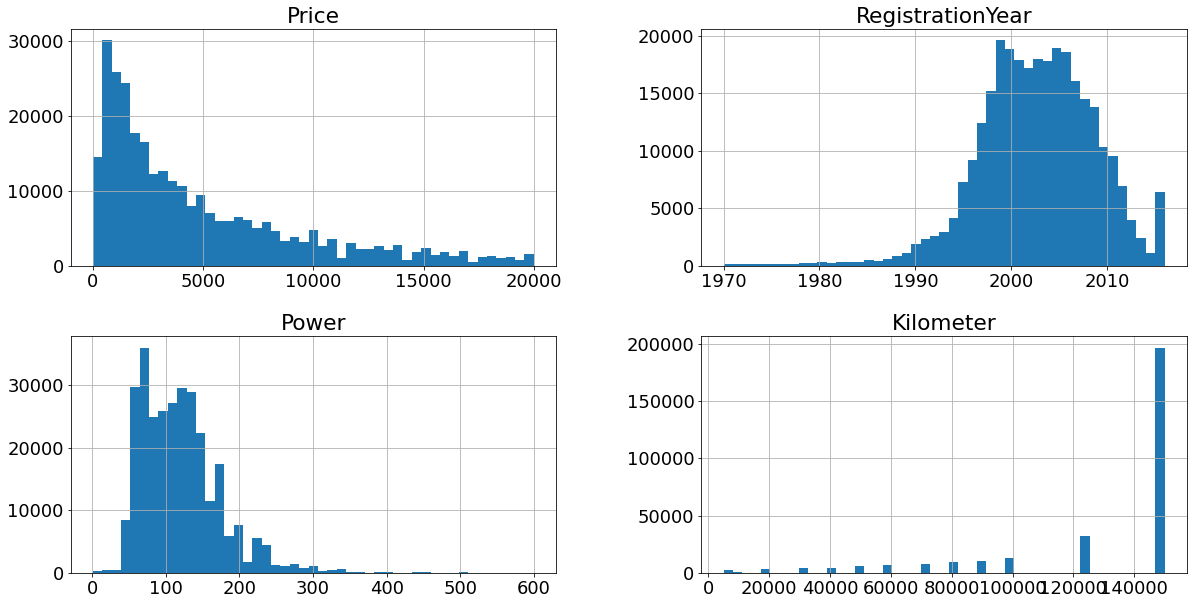

In [28]:
# гистограммы количественных данных после обработки
df[df.select_dtypes(exclude=[object]).columns].hist(figsize=(20, 10), bins=47)
print('Гистограммы по столбцам количственных данныхх:')

In [29]:
# В категориальных признаках заполним пропуски (в количественных пропусков не было изначально) 
df.fillna('unknown', inplace=True)

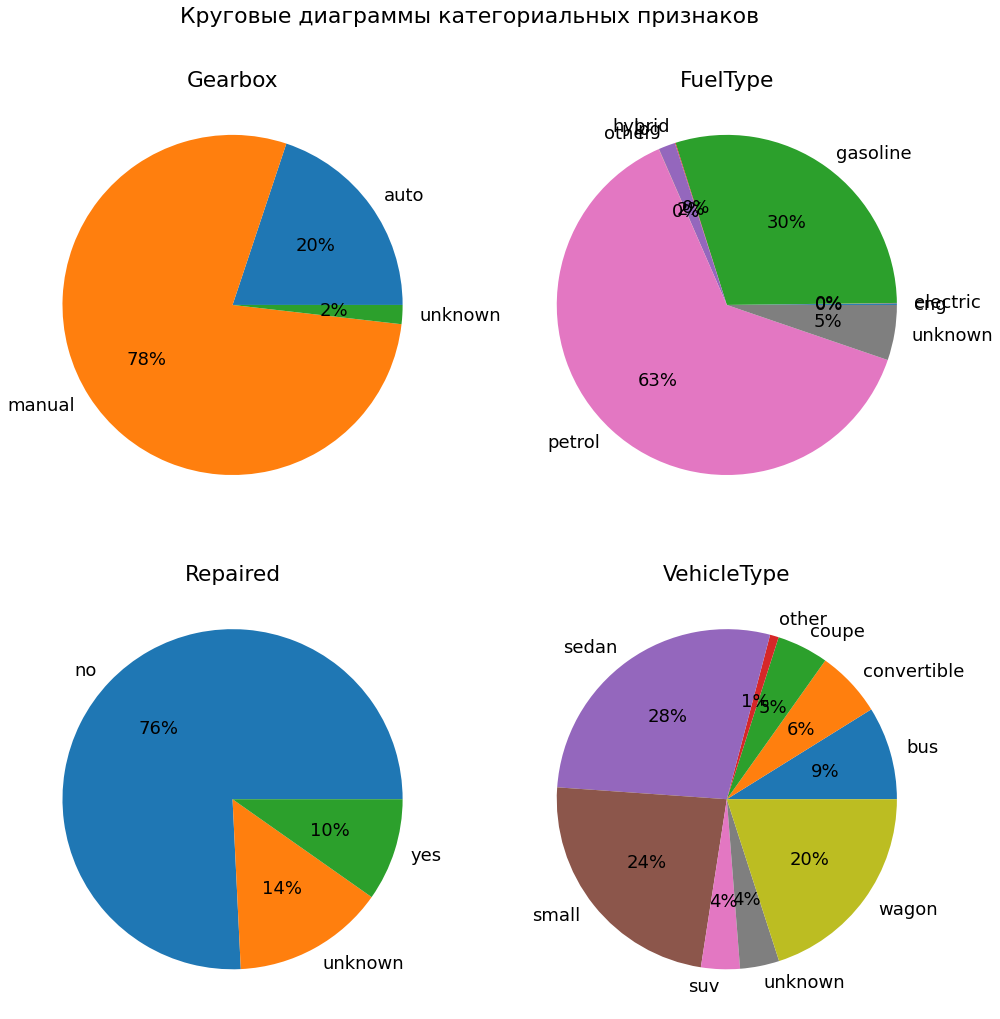

In [30]:
# Далее изучим категориальные признаки. 
cat_graph(df, df[['Gearbox','FuelType','Repaired','VehicleType']].columns) 
#в столбцах с моделью и брендом очень много значений, они буду неинформтивно смотреться, 
#информация о них есть в кратком описании датасета выше

In [31]:
# если не ошибаюсь, то petrol и gasoline это одно и то же
df.loc[df['FuelType'] == 'petrol','FuelType'] = 'gasoline'

Как видно в данных есть дисбаланс. Подавляющее большенство машин бензиновые (92%). 3/4 машин точно не были в ремонте. Минимум 78% машин с ручной коробкой передач. Основные 3 типа транспортного средства: sedan - 28%, small - 24%, wagon - 20%.  


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295849 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             295849 non-null  int64 
 1   VehicleType       295849 non-null  object
 2   RegistrationYear  295849 non-null  int64 
 3   Gearbox           295849 non-null  object
 4   Power             295849 non-null  int64 
 5   Model             295849 non-null  object
 6   Kilometer         295849 non-null  int64 
 7   FuelType          295849 non-null  object
 8   Brand             295849 non-null  object
 9   Repaired          295849 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.8+ MB


In [35]:
# Теперь удалим дублиукаты
df = df.drop_duplicates()

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256064 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             256064 non-null  int64 
 1   VehicleType       256064 non-null  object
 2   RegistrationYear  256064 non-null  int64 
 3   Gearbox           256064 non-null  object
 4   Power             256064 non-null  int64 
 5   Model             256064 non-null  object
 6   Kilometer         256064 non-null  int64 
 7   FuelType          256064 non-null  object
 8   Brand             256064 non-null  object
 9   Repaired          256064 non-null  object
dtypes: int64(4), object(6)
memory usage: 21.5+ MB


In [38]:
df.duplicated().sum()

0

In [40]:
#отделим целевую переменную от признаков.
target = df['Price']
features = df.drop(['Price'], axis=1)
#разбиваем на две выборки в отношении 1:3
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

In [42]:
print(len(features_train),len(features_test))

192048 64016


In [67]:
#используем TargetEncoder
tenc=TargetEncoder()

# обучаем шифровальщика на тренировочной выборке и применяем к ней
features_train_encoded = tenc.fit_transform(
    features_train[df.select_dtypes(include='object').columns], target_train).join(
    features_train.drop(df.select_dtypes(include='object').columns, axis = 1))

# применяем обученный шифровальщик к тестовой выборке
features_test_encoded = tenc.transform(
    features_test[df.select_dtypes(include='object').columns]).join(
    features_test.drop(df.select_dtypes(include='object').columns, axis = 1))

print(features_train_encoded.head())
print(features_test_encoded.head())

        VehicleType      Gearbox        Model     FuelType        Brand  \
209828  2559.504087  4400.441439  5536.126845  5085.653886  6748.257651   
70384   5203.568528  4400.441439  3457.480201  5085.653886  3390.396401   
6665    5203.568528  7187.622741  5802.467776  5085.653886  6297.908637   
155462  5067.666736  4400.441439  2787.080972  5085.653886  2649.967934   
115033  5775.045841  4400.441439  4724.897285  5085.653886  2649.967934   

           Repaired  RegistrationYear  Power  Kilometer  
209828  2167.003013              2016    115     150000  
70384   5698.890832              1997     75     150000  
6665    5698.890832              2007    150     150000  
155462  5698.890832              2001    107     150000  
115033  5698.890832              2011    131     150000  
        VehicleType      Gearbox        Model     FuelType        Brand  \
335925  5067.666736  7187.622741  7896.192872  2768.851185  6297.908637   
325274  3030.326993  2936.097092  3824.389610  4656

**Промежуточные выводы**

1. Данные были загружены и обработаны. Удалены явные дубликаты. Удалены неинформативные столбцы: 'DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'RegistrationMonth', 'PostalCode'. Пропуски данных обнаружены только в категориальных данных, пропуски заполнены заглушкой 'unknown'. Аномальные значения в количественных данных обнаружены и обработаны. 

2. Рассматриваются только авто которые зарегестрированы с 1970 по 2016 года можностью до 600 л.с. Более старые и более мощные авто не рассматриваются, так как таких мало в выборке и это может сказаться на качестве модели. Максимальное и самое распространенное значение пробега 150000 км, вероятно реальные значения пробега выше и 150000 каким-то образом оказалось максимально возможным числом в датасете. 

3. В категориальных признаках наблюдается дисбаланс. Подавляющее большенство машин бензиновые (92%). 3/4 машин точно не были в ремонте. Минимум 78% машин с ручной коробкой передач. Основные 3 типа транспортного средства: sedan - 28%, small - 24%, wagon - 20%.  

4. Данные разбиты на тестовую и тренировочную выборки в отношении 1:3

5. Категориальные признаки кодированы при помощи TargetEncoder 

## Обучение и анализ моделей

Ниже рассмотрим 3 модели (параметров будет подбираться немного, так как считается довольно долго)

**LightGBM**

In [68]:
features_train_cat = features_train.copy()
features_test_cat = features_test.copy()
for col in df.select_dtypes(include='object').columns:
    features_train_cat[col] = features_train_cat[col].astype('category')
    features_test_cat[col] = features_test_cat[col].astype('category')

In [69]:
# параметры, которые будем подбирать
param = {'learning_rate': [0.1, 0.2],'n_estimators': [10, 20]}

estimator = LGBMRegressor(random_state=RANDOM_STATE)

#подбор параметров и обучение
model = GridSearchCV(estimator=estimator, param_grid=param,cv=3, n_jobs=4, scoring='neg_root_mean_squared_error',refit=False)
model.fit(features_train_cat, target_train)

# Результат
print('Параметры:', model.best_params_)
print('RMSE:', model.best_score_*(-1))

Параметры: {'learning_rate': 0.2, 'n_estimators': 20}
RMSE: 1723.7889162933473


In [70]:
#лучшая модель LightGBM
model = LGBMRegressor(random_state=RANDOM_STATE, n_jobs=4, **model.best_params_)
#Время обучения модели
%timeit model.fit(features_train_cat, target_train)

1.99 s ± 353 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [71]:
# время предсказаний
%timeit model.predict(features_train_cat)

430 ms ± 32.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**CatBoostRegressor**

In [72]:
param = {'depth': [3, 5], 'learning_rate': [0.01, 0.1]}

estimator = CatBoostRegressor(loss_function="RMSE", iterations=60, random_state=RANDOM_STATE)

#подбор параметров и обучение
model = GridSearchCV(estimator=estimator, param_grid=param,cv=3, n_jobs=4, scoring='neg_root_mean_squared_error', refit=False)
model.fit(features_train, target_train, cat_features =  df.select_dtypes(include='object').columns.tolist())

# Результат
print('Параметры:', model.best_params_)
print('RMSE:', model.best_score_*(-1))

0:	learn: 4636.9653373	total: 127ms	remaining: 7.48s
1:	learn: 4611.4710622	total: 224ms	remaining: 6.5s
2:	learn: 4586.2623299	total: 297ms	remaining: 5.64s
3:	learn: 4561.3699893	total: 362ms	remaining: 5.06s
4:	learn: 4537.2449650	total: 523ms	remaining: 5.76s
5:	learn: 4513.2615191	total: 641ms	remaining: 5.77s
6:	learn: 4489.3472944	total: 748ms	remaining: 5.67s
7:	learn: 4465.8196054	total: 920ms	remaining: 5.98s
8:	learn: 4442.5826434	total: 1.03s	remaining: 5.85s
9:	learn: 4419.7401651	total: 1.22s	remaining: 6.09s
10:	learn: 4397.1490229	total: 1.33s	remaining: 5.92s
11:	learn: 4375.1856663	total: 1.45s	remaining: 5.79s
12:	learn: 4353.3793190	total: 1.62s	remaining: 5.87s
13:	learn: 4331.6932122	total: 1.74s	remaining: 5.72s
14:	learn: 4310.4341266	total: 1.85s	remaining: 5.54s
15:	learn: 4289.0543428	total: 2.02s	remaining: 5.55s
16:	learn: 4268.3127799	total: 2.11s	remaining: 5.35s
17:	learn: 4247.8617647	total: 2.21s	remaining: 5.17s
18:	learn: 4227.3860635	total: 2.32s	re

In [73]:
#лучшая модель CatBoostRegressor
model = CatBoostRegressor(loss_function="RMSE", iterations=60, random_state=RANDOM_STATE, **model.best_params_)
#Время очучения модели
%timeit model.fit(features_train, target_train, cat_features =  df.select_dtypes(include='object').columns.tolist())

0:	learn: 4370.6856648	total: 95.9ms	remaining: 5.66s
1:	learn: 4122.5077671	total: 172ms	remaining: 5s
2:	learn: 3885.5830021	total: 243ms	remaining: 4.62s
3:	learn: 3685.0480078	total: 331ms	remaining: 4.64s
4:	learn: 3506.6058596	total: 410ms	remaining: 4.51s
5:	learn: 3347.5742002	total: 486ms	remaining: 4.37s
6:	learn: 3210.6521061	total: 577ms	remaining: 4.37s
7:	learn: 3084.3345720	total: 653ms	remaining: 4.24s
8:	learn: 2974.6926639	total: 719ms	remaining: 4.07s
9:	learn: 2872.6833805	total: 786ms	remaining: 3.93s
10:	learn: 2786.6370620	total: 864ms	remaining: 3.85s
11:	learn: 2714.7441438	total: 931ms	remaining: 3.72s
12:	learn: 2645.8877593	total: 996ms	remaining: 3.6s
13:	learn: 2575.1539336	total: 1.08s	remaining: 3.54s
14:	learn: 2517.8444732	total: 1.15s	remaining: 3.44s
15:	learn: 2464.5791465	total: 1.23s	remaining: 3.37s
16:	learn: 2418.0443577	total: 1.29s	remaining: 3.27s
17:	learn: 2375.2725332	total: 1.37s	remaining: 3.19s
18:	learn: 2337.5966822	total: 1.44s	rema

In [74]:
#время предсказаний
%timeit model.predict(features_train)

263 ms ± 6.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Случайный лес**

In [75]:
# Гиперпараметры для перебора
param = {'max_depth': [5, 10],'n_estimators': [10, 20]}

estimator = RandomForestRegressor(random_state=RANDOM_STATE)

#подбор параметров и обучение
model = GridSearchCV(estimator=estimator, param_grid=param,cv=3, scoring='neg_root_mean_squared_error', refit=False)
model.fit(features_train_encoded, target_train)

# Результат
print('Параметры:', model.best_params_)
print('RMSE:', model.best_score_*(-1))

Параметры: {'max_depth': 10, 'n_estimators': 20}
RMSE: 1825.0438615814649


In [76]:
#лучшая модель случайного леса
model = RandomForestRegressor(random_state=RANDOM_STATE, **model.best_params_)
#Время очучения модели
%timeit model.fit(features_train_encoded, target_train)

5.94 s ± 202 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [77]:
# время предсказаний
%timeit model.predict(features_train_encoded)

400 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## **Промежуточный вывод**


Результат анализа моделей:
    
    LGBM         : RMSE 1724, среднее время обучения 1 с., среднее время предсказания 430 мс
    
    catBoost     : RMSE 1898, среднее время обучения 5.86 с., среднее время предсказания 263 мс
    
    случайный лес: RMSE 1825, среднее время обучения 5.94 с., среднее время предсказания 400 мс
    
Как видно, LGBM оказалась лучше по качеству предсказаний и скорости обучения, зато хуже всех по скорости предсказаний. Так как заказчику важны все три фактора, то далее выберем модель LGBM как лучшую. Отметим, правда, что все модели проходят по критерию качества так как RSME любой модели меньше 2500

## Проверка качества лучшей модели

In [78]:
#лучшая модель LightGBM
model = LGBMRegressor(random_state=RANDOM_STATE, learning_rate=0.2 ,n_estimators=20, n_jobs=4)

#обучим модель и построим предсказания на тестовой выборке
model.fit(features_train_cat, target_train)
predictions = model.predict(features_test_cat)

# RMSE модели на тестовой выборке
mean_squared_error(target_test, predictions, squared=False)

1722.9061657853065

In [80]:
#проверим, что эта модель лучше константной модели
constant = target_train.mean()
constant_predictions = constant * np.ones((len(target_test),1))

# RMSE тривиальной модели
mean_squared_error(target_test, constant_predictions, squared=False)

4649.329359538626

**Промежуточный вывод**

Выбранная модель показала хороший результат на тестовой выборке по метрике RMSE: 1723.

Модель прошла проверку на адекватность, RMSE тривиальной модели, предсказывающей цену авто как среднюю цену всех известных модели авто сильно выше - 4649 

## Общий вывод

Работа по построению моли предсказания стоимости автомобиля состояла из трех частей:
    
   **1.** Данные были загружены и обработаны. Удалены явные дубликаты. Удалены неинформативные столбцы: 'DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'RegistrationMonth', 'PostalCode'. Пропуски данных обнаружены только в категориальных данных, пропуски заполнены заглушкой 'unknown'. Аномальные значения в количественных данных обнаружены и обработаны. Рассматриваются только авто которые зарегестрированы с 1970 по 2016 года можностью до 600 л.с. Более старые и более мощные авто не рассматриваются, так как таких мало в выборке и это может сказаться на качестве модели. Максимальное и самое распространенное значение пробега 150000 км, вероятно реальные значения пробега выше и 150000 каким-то образом оказалось максимально возможным числом в датасете. В категориальных признаках наблюдается дисбаланс. Подавляющее большенство машин бензиновые (92%). 3/4 машин точно не были в ремонте. Минимум 78% машин с ручной коробкой передач. Основные 3 типа транспортного средства: sedan - 28%, small - 24%, wagon - 20%. Данные разбиты на тестовую и тренировочную выборки в отношении 1:3
    
   **2.** Исследовано три модели с различными гиперпараметрами.Результат анализа моделей:
    
    
    LGBM         : RMSE 1724, среднее время обучения 1 с., среднее время предсказания 430 мс
    
    catBoost     : RMSE 1898, среднее время обучения 5.86 с., среднее время предсказания 263 мс
    
    случайный лес: RMSE 1825, среднее время обучения 5.94 с., среднее время предсказания 400 мс
    
    
   Как видно, LGBM оказалась лучше по качеству предсказаний и скорости обучения, зато хуже всех по скорости предсказаний. Так как заказчику важны все три фактора, то далее выберем модель LGBM как лучшую. Отметим, правда, что все модели проходят по критерию качества так как RSME любой модели меньше 2500. При этом скорость зависит также от гиперпараметров. Однако, изучение большого колиества гиперпараметров не входило в цели этой работы, поэтому просто отметим, что при изменении гиперпараметров результат может измениться и в пользу другой модели
    
   **3.** Выбранная модель показала хороший результат на тестовой выборке по метрике RMSE: 1766.
    Выбранная модель показала хороший результат на тестовой выборке по метрике RMSE: 1723.

Модель прошла проверку на адекватность, RMSE тривиальной модели, предсказывающей цену авто как среднюю цену всех известных модели авто сильно выше - 4649 